In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader , Dataset
import spacy
import nltk
from nltk.corpus import brown
from torchsummary import summary
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import accuracy_score

## Using POS tagger en_core_web_sm

In [2]:
pos = spacy.load("en_core_web_sm")

In [3]:
sample=pos("Hi , my name is Srinivas")
sample

Hi , my name is Srinivas

In [4]:
for _ in sample:
    print(_.text," --> ",_.pos_)

Hi  -->  INTJ
,  -->  PUNCT
my  -->  PRON
name  -->  NOUN
is  -->  AUX
Srinivas  -->  PROPN


## Using News category of Brown corpus to generate vocabulary and pos tags for training of models and testing on other categories

In [5]:
brown.categories()

['adventure',
 'belles_lettres',
 'editorial',
 'fiction',
 'government',
 'hobbies',
 'humor',
 'learned',
 'lore',
 'mystery',
 'news',
 'religion',
 'reviews',
 'romance',
 'science_fiction']

In [6]:
brown.words(categories='news')

['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', ...]

In [7]:
len(brown.tagged_words(categories='news'))

100554

In [8]:
brown.tagged_words(categories='news')

[('The', 'AT'), ('Fulton', 'NP-TL'), ...]

In [9]:
for i in range(10):
    print(brown.tagged_words(categories='news')[i])

('The', 'AT')
('Fulton', 'NP-TL')
('County', 'NN-TL')
('Grand', 'JJ-TL')
('Jury', 'NN-TL')
('said', 'VBD')
('Friday', 'NR')
('an', 'AT')
('investigation', 'NN')
('of', 'IN')


In [10]:
words= [word[0] for word in brown.tagged_words(categories='news')]
len(words)

100554

In [11]:
labels= [label[1] for label in brown.tagged_words(categories='news')]
len(labels)

100554

In [12]:
df= pd.DataFrame()

In [13]:
df["words"]=words
df["labels"]=labels

In [14]:
df.shape

(100554, 2)

In [15]:
df.head()

,words,labels
0,The,AT
1,Fulton,NP-TL
2,County,NN-TL
3,Grand,JJ-TL
4,Jury,NN-TL


In [16]:
df["labels"].unique()

array(['AT', 'NP-TL', 'NN-TL', 'JJ-TL', 'VBD', 'NR', 'NN', 'IN', 'NP$',
       'JJ', '``', "''", 'CS', 'DTI', 'NNS', '.', 'RBR', ',', 'WDT',
       'HVD', 'VBZ', 'CC', 'IN-TL', 'BEDZ', 'VBN', 'NP', 'BEN', 'TO',
       'VB', 'RB', 'DT', 'PPS', 'DOD', 'AP', 'BER', 'HV', 'DTS', 'VBG',
       'PPO', 'QL', 'JJT', 'ABX', 'NN-HL', 'VBN-HL', 'WRB', 'CD', 'MD',
       'BE', 'JJR', 'VBG-TL', 'BEZ', 'NN$-TL', 'HVZ', 'ABN', 'PN', 'PPSS',
       'PP$', 'DO', 'NN$', 'NNS-HL', 'WPS', '*', 'EX', 'VB-HL', ':', '(',
       ')', 'NNS-TL', 'NPS', 'JJS', 'RP', '--', 'BED', 'OD', 'BEG',
       'AT-HL', 'VBG-HL', 'AT-TL', 'PPL', 'DOZ', 'NP-HL', 'NR$', 'DOD*',
       'BEDZ*', ',-HL', 'CC-TL', 'MD*', 'NNS$', 'PPSS+BER', "'",
       'PPSS+BEM', 'CD-TL', 'RBT', '(-HL', ')-HL', 'MD-HL', 'VBZ-HL',
       'IN-HL', 'JJ-HL', 'PPLS', 'CD-HL', 'WPO', 'JJS-TL', 'ABL',
       'BER-HL', 'PPS+HVZ', 'VBD-HL', 'RP-HL', 'MD*-HL', 'AP-HL', 'CS-HL',
       'DT$', 'HVN', 'FW-IN', 'FW-DT', 'VBN-TL', 'NR-TL', 'NNS$-TL',
       'FW

In [17]:
df["labels"].nunique()

218

# --------------------------------------

In [18]:
brown.sents(categories="news")

[['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.'], ['The', 'jury', 'further', 'said', 'in', 'term-end', 'presentments', 'that', 'the', 'City', 'Executive', 'Committee', ',', 'which', 'had', 'over-all', 'charge', 'of', 'the', 'election', ',', '``', 'deserves', 'the', 'praise', 'and', 'thanks', 'of', 'the', 'City', 'of', 'Atlanta', "''", 'for', 'the', 'manner', 'in', 'which', 'the', 'election', 'was', 'conducted', '.'], ...]

In [19]:
len(brown.sents(categories="news"))

4623

In [20]:
brown_sentences= [ " ".join(sentence) for sentence in brown.sents(categories="news") ]

In [21]:
brown_sentences[:10]

["The Fulton County Grand Jury said Friday an investigation of Atlanta's recent primary election produced `` no evidence '' that any irregularities took place .",
 "The jury further said in term-end presentments that the City Executive Committee , which had over-all charge of the election , `` deserves the praise and thanks of the City of Atlanta '' for the manner in which the election was conducted .",
 "The September-October term jury had been charged by Fulton Superior Court Judge Durwood Pye to investigate reports of possible `` irregularities '' in the hard-fought primary which was won by Mayor-nominate Ivan Allen Jr. .",
 "`` Only a relative handful of such reports was received '' , the jury said , `` considering the widespread interest in the election , the number of voters and the size of this city '' .",
 "The jury said it did find that many of Georgia's registration and election laws `` are outmoded or inadequate and often ambiguous '' .",
 "It recommended that Fulton legisla

In [22]:
brown_tags = [ {word.text: word.pos_ for word in pos(sentence)} for sentence in brown_sentences]

In [23]:
brown_tags[0]

{'The': 'DET',
 'Fulton': 'PROPN',
 'County': 'PROPN',
 'Grand': 'PROPN',
 'Jury': 'PROPN',
 'said': 'VERB',
 'Friday': 'PROPN',
 'an': 'DET',
 'investigation': 'NOUN',
 'of': 'ADP',
 'Atlanta': 'PROPN',
 "'s": 'PART',
 'recent': 'ADJ',
 'primary': 'ADJ',
 'election': 'NOUN',
 'produced': 'VERB',
 '`': 'PUNCT',
 'no': 'DET',
 'evidence': 'NOUN',
 "''": 'PUNCT',
 'that': 'SCONJ',
 'any': 'DET',
 'irregularities': 'NOUN',
 'took': 'VERB',
 'place': 'NOUN',
 '.': 'PUNCT'}

### building vocabulary

In [24]:
words = set()
tags = set()

In [25]:
words = [word for sentence in brown_tags for word in sentence.keys() ]
tags = [tag for sentence in brown_tags for tag in sentence.values()]

In [26]:
len(words)

92275

In [27]:
unique_words=sorted(list(set(words)))

In [28]:
unique_words[:10]

['!', '$', '%', '&', "'", "''", "'d", "'em", "'ll", "'m"]

In [29]:
len(unique_words)

13407

In [30]:
unique_words.index("9th")

578

In [31]:
unique_words.index("1,000")

21

In [32]:
del unique_words[21:578]
len(unique_words)

12850

In [33]:
unique_words_id = { j:i for i,j in enumerate(unique_words)}

In [38]:
list(unique_words_id.items())[:10]

[('!', 0),
 ('$', 1),
 ('%', 2),
 ('&', 3),
 ("'", 4),
 ("''", 5),
 ("'d", 6),
 ("'em", 7),
 ("'ll", 8),
 ("'m", 9)]

In [39]:
unique_tags=sorted(list(set(tags)))
unique_tags

['ADJ',
 'ADP',
 'ADV',
 'AUX',
 'CCONJ',
 'DET',
 'INTJ',
 'NOUN',
 'NUM',
 'PART',
 'PRON',
 'PROPN',
 'PUNCT',
 'SCONJ',
 'SYM',
 'VERB',
 'X']

In [40]:
unique_tags_id = { j:i for i,j in enumerate(unique_tags)}

In [41]:
unique_tags_id

{'ADJ': 0,
 'ADP': 1,
 'ADV': 2,
 'AUX': 3,
 'CCONJ': 4,
 'DET': 5,
 'INTJ': 6,
 'NOUN': 7,
 'NUM': 8,
 'PART': 9,
 'PRON': 10,
 'PROPN': 11,
 'PUNCT': 12,
 'SCONJ': 13,
 'SYM': 14,
 'VERB': 15,
 'X': 16}

In [42]:
sample= "hi , I am srinivas"
pos(sample)

hi , I am srinivas

In [43]:
unique_words_id["unknown"]

12364

### Final Vocabulary

In [44]:
[{sample.text:sample.pos_} for sample in pos(" ".join(unique_words))][:4]

[{'!': 'PUNCT'}, {'$': 'SYM'}, {'%': 'NOUN'}, {'&': 'CCONJ'}]

In [45]:
merge_brown_tags={}
for d in brown_tags:
    merge_brown_tags.update(d)

In [47]:
list(merge_brown_tags.items())[:10]

[('The', 'DET'),
 ('Fulton', 'PROPN'),
 ('County', 'PROPN'),
 ('Grand', 'PROPN'),
 ('Jury', 'PROPN'),
 ('said', 'VERB'),
 ('Friday', 'PROPN'),
 ('an', 'DET'),
 ('investigation', 'NOUN'),
 ('of', 'ADP')]

In [48]:
brown_sentences[:4]

["The Fulton County Grand Jury said Friday an investigation of Atlanta's recent primary election produced `` no evidence '' that any irregularities took place .",
 "The jury further said in term-end presentments that the City Executive Committee , which had over-all charge of the election , `` deserves the praise and thanks of the City of Atlanta '' for the manner in which the election was conducted .",
 "The September-October term jury had been charged by Fulton Superior Court Judge Durwood Pye to investigate reports of possible `` irregularities '' in the hard-fought primary which was won by Mayor-nominate Ivan Allen Jr. .",
 "`` Only a relative handful of such reports was received '' , the jury said , `` considering the widespread interest in the election , the number of voters and the size of this city '' ."]

In [49]:
brown_tags[:4]

[{'The': 'DET',
  'Fulton': 'PROPN',
  'County': 'PROPN',
  'Grand': 'PROPN',
  'Jury': 'PROPN',
  'said': 'VERB',
  'Friday': 'PROPN',
  'an': 'DET',
  'investigation': 'NOUN',
  'of': 'ADP',
  'Atlanta': 'PROPN',
  "'s": 'PART',
  'recent': 'ADJ',
  'primary': 'ADJ',
  'election': 'NOUN',
  'produced': 'VERB',
  '`': 'PUNCT',
  'no': 'DET',
  'evidence': 'NOUN',
  "''": 'PUNCT',
  'that': 'SCONJ',
  'any': 'DET',
  'irregularities': 'NOUN',
  'took': 'VERB',
  'place': 'NOUN',
  '.': 'PUNCT'},
 {'The': 'DET',
  'jury': 'NOUN',
  'further': 'ADV',
  'said': 'VERB',
  'in': 'ADP',
  'term': 'NOUN',
  '-': 'PUNCT',
  'end': 'NOUN',
  'presentments': 'NOUN',
  'that': 'SCONJ',
  'the': 'DET',
  'City': 'PROPN',
  'Executive': 'PROPN',
  'Committee': 'PROPN',
  ',': 'PUNCT',
  'which': 'PRON',
  'had': 'VERB',
  'over': 'ADP',
  'all': 'PRON',
  'charge': 'NOUN',
  'of': 'ADP',
  'election': 'NOUN',
  '`': 'PUNCT',
  'deserves': 'VERB',
  'praise': 'NOUN',
  'and': 'CCONJ',
  'thanks': 'N

In [50]:
brown_tags_sentences = [[tag.pos_ for tag in pos(sentence)] for sentence in brown_sentences]

In [58]:
brown_tags_sentences[:2]

[['DET',
  'PROPN',
  'PROPN',
  'PROPN',
  'PROPN',
  'VERB',
  'PROPN',
  'DET',
  'NOUN',
  'ADP',
  'PROPN',
  'PART',
  'ADJ',
  'ADJ',
  'NOUN',
  'VERB',
  'PUNCT',
  'PUNCT',
  'DET',
  'NOUN',
  'PUNCT',
  'SCONJ',
  'DET',
  'NOUN',
  'VERB',
  'NOUN',
  'PUNCT'],
 ['DET',
  'NOUN',
  'ADV',
  'VERB',
  'ADP',
  'NOUN',
  'PUNCT',
  'NOUN',
  'NOUN',
  'SCONJ',
  'DET',
  'PROPN',
  'PROPN',
  'PROPN',
  'PUNCT',
  'PRON',
  'VERB',
  'ADP',
  'PUNCT',
  'PRON',
  'NOUN',
  'ADP',
  'DET',
  'NOUN',
  'PUNCT',
  'PUNCT',
  'PUNCT',
  'VERB',
  'DET',
  'NOUN',
  'CCONJ',
  'NOUN',
  'ADP',
  'DET',
  'PROPN',
  'ADP',
  'PROPN',
  'PUNCT',
  'ADP',
  'DET',
  'NOUN',
  'ADP',
  'PRON',
  'DET',
  'NOUN',
  'AUX',
  'VERB',
  'PUNCT']]

### Indexing based on vocabulary built on unique (english words and  pos tags)

In [52]:
def index_sentences(sentence,tags):
    return [unique_words_id[word] if word in unique_words else unique_words_id["unknown"] for word in sentence.split() ] , [ unique_tags_id [tag] for tag in tags]

In [53]:
sample= "hi , I am srinivas"
pos(sample)

hi , I am srinivas

In [54]:
index_sentences( sample , [i.pos_ for i in pos(sample)] )

([12364, 15, 1894, 4566, 12364], [6, 12, 10, 3, 0])

In [55]:
id_brown_sentences=[]
id_brown_tags_sentences=[]

for i,j in zip(brown_sentences,brown_tags_sentences):
    a,b = index_sentences(i,j)
    id_brown_sentences.append(a)
    id_brown_tags_sentences.append(b)

In [56]:
id_brown_sentences[:4]

[[3851,
  1495,
  964,
  1630,
  2068,
  10836,
  1483,
  4589,
  8368,
  9384,
  12364,
  10393,
  10050,
  6802,
  10093,
  12364,
  9275,
  7031,
  5,
  11969,
  4629,
  8393,
  12095,
  9825,
  18],
 [3851,
  8462,
  7564,
  10836,
  8146,
  12364,
  10012,
  11969,
  11970,
  799,
  1327,
  869,
  15,
  12681,
  7804,
  12364,
  5518,
  9384,
  11970,
  6802,
  15,
  12364,
  6410,
  11970,
  9965,
  4593,
  11968,
  9384,
  11970,
  799,
  9384,
  260,
  5,
  7427,
  11970,
  8854,
  8146,
  12681,
  11970,
  6802,
  12615,
  5856,
  18],
 [3851,
  12364,
  11945,
  8462,
  7804,
  5001,
  5519,
  5332,
  1495,
  3767,
  967,
  2057,
  1196,
  3156,
  12072,
  8365,
  10570,
  9384,
  9935,
  12364,
  8393,
  5,
  8146,
  11970,
  12364,
  10050,
  12681,
  12615,
  12757,
  5332,
  12364,
  1990,
  129,
  2055,
  18],
 [12364,
  2860,
  4286,
  10494,
  7826,
  9384,
  11710,
  10570,
  12615,
  10390,
  5,
  15,
  11970,
  8462,
  10836,
  15,
  12364,
  5911,
  11970,
  12704,

In [57]:
id_brown_tags_sentences[:4]

[[5,
  11,
  11,
  11,
  11,
  15,
  11,
  5,
  7,
  1,
  11,
  9,
  0,
  0,
  7,
  15,
  12,
  12,
  5,
  7,
  12,
  13,
  5,
  7,
  15,
  7,
  12],
 [5,
  7,
  2,
  15,
  1,
  7,
  12,
  7,
  7,
  13,
  5,
  11,
  11,
  11,
  12,
  10,
  15,
  1,
  12,
  10,
  7,
  1,
  5,
  7,
  12,
  12,
  12,
  15,
  5,
  7,
  4,
  7,
  1,
  5,
  11,
  1,
  11,
  12,
  1,
  5,
  7,
  1,
  10,
  5,
  7,
  3,
  15,
  12],
 [5,
  11,
  12,
  11,
  7,
  7,
  3,
  3,
  15,
  1,
  11,
  11,
  11,
  11,
  11,
  11,
  9,
  15,
  7,
  1,
  0,
  12,
  12,
  7,
  12,
  1,
  5,
  2,
  12,
  15,
  7,
  10,
  3,
  15,
  1,
  11,
  12,
  7,
  11,
  11,
  11,
  12],
 [12,
  12,
  2,
  5,
  0,
  7,
  1,
  0,
  7,
  3,
  15,
  12,
  12,
  5,
  7,
  15,
  12,
  12,
  12,
  15,
  5,
  0,
  7,
  1,
  5,
  7,
  12,
  5,
  7,
  1,
  7,
  4,
  5,
  7,
  1,
  5,
  7,
  12,
  12]]

In [59]:
class model(nn.Module):
    def __init__(self,vocab_size,embedding_size,output_size,hidden_units):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size,embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_units , batch_first=True)
        self.final = nn.Linear(hidden_units,output_size)
        
    def forward(self,x):
        y=self.embeddings(x)
        y,_=self.lstm(y)
        y=self.final(y)
        y=torch.log_softmax(y, dim=2)
        return y

In [60]:
vocab_size = len(unique_words)
embedding_size = 128
output_size = len(unique_tags)
hidden_units = 256

In [61]:
lstm = model(vocab_size,embedding_size,output_size,hidden_units)

In [62]:
class posdata(Dataset):
    def __init__(self,sentences,tags):
        self.sentences = sentences
        self.tags = tags
        
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self,id_):
        return torch.tensor(self.sentences[id_], dtype=torch.long), torch.tensor(self.tags[id_], dtype=torch.long)

In [63]:
df = posdata(id_brown_sentences , id_brown_tags_sentences)

In [64]:
def custom_collate_fn(batch):
    sequences, labels = zip(*batch)
    
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0)
    padded_labels = pad_sequence(labels, batch_first=True, padding_value=-1)
    
    sequence_lengths = torch.tensor([len(seq) for seq in sequences], dtype=torch.long)
    max_length = padded_sequences.size(1)
    mask = torch.arange(max_length).expand(len(sequences), max_length) < sequence_lengths.unsqueeze(1)
    
    return padded_sequences, padded_labels, mask

In [65]:
data_loader = DataLoader(df , batch_size=16 , shuffle=True,collate_fn=custom_collate_fn)

In [66]:
for i,j in lstm.named_parameters():
    print(i," ",j.shape)

embeddings.weight   torch.Size([12850, 128])
lstm.weight_ih_l0   torch.Size([1024, 128])
lstm.weight_hh_l0   torch.Size([1024, 256])
lstm.bias_ih_l0   torch.Size([1024])
lstm.bias_hh_l0   torch.Size([1024])
final.weight   torch.Size([17, 256])
final.bias   torch.Size([17])


In [67]:
loss_fn = nn.NLLLoss(ignore_index=-1)
optimizer = torch.optim.Adam(lstm.parameters(),lr=0.01)

### Using adventure data of brown corpus for evaluation and humor data for testing

In [68]:
brown_eval_sentences = [" ".join(sentence) for sentence in brown.sents(categories="adventure")]

In [69]:
brown_tags_eval_sentences = [[tag.pos_ for tag in pos(sentence)] for sentence in brown_eval_sentences]

In [70]:
id_brown_eval_sentences=[]
id_brown_tags_eval_sentences=[]

for i,j in zip(brown_eval_sentences,brown_tags_eval_sentences):
    a,b = index_sentences(i,j)
    id_brown_eval_sentences.append(a)
    id_brown_tags_eval_sentences.append(b)

In [71]:
brown_test_sentences = [" ".join(sentence) for sentence in brown.sents(categories="humor")]

In [72]:
brown_tags_test_sentences = [[tag.pos_ for tag in pos(sentence)] for sentence in brown_test_sentences]

In [73]:
id_brown_test_sentences=[]
id_brown_tags_test_sentences=[]

for i,j in zip(brown_test_sentences,brown_tags_test_sentences):
    a,b = index_sentences(i,j)
    id_brown_test_sentences.append(a)
    id_brown_tags_test_sentences.append(b)

In [74]:
brown_train_eval_sentences=[]
brown_train_eval_sentences +=brown_sentences
brown_train_eval_sentences +=brown_eval_sentences
len(brown_train_eval_sentences)

9260

In [75]:
brown_tags_train_eval_sentences=[]
brown_tags_train_eval_sentences +=brown_tags_sentences
brown_tags_train_eval_sentences +=brown_tags_eval_sentences
len(brown_tags_train_eval_sentences)

9260

In [76]:
id_brown_train_eval_sentences=[]
id_brown_tags_train_eval_sentences=[]

for i,j in zip(brown_train_eval_sentences,brown_tags_train_eval_sentences):
    a,b = index_sentences(i,j)
    id_brown_train_eval_sentences.append(a)
    id_brown_tags_train_eval_sentences.append(b)

In [91]:
data_loader_eval = DataLoader( posdata(id_brown_eval_sentences , id_brown_tags_eval_sentences), batch_size=16 , shuffle=True,collate_fn=custom_collate_fn)

In [92]:
data_loader_test = DataLoader( posdata(id_brown_test_sentences , id_brown_tags_test_sentences), batch_size=16 , shuffle=True,collate_fn=custom_collate_fn)

In [93]:
data_loader_train_eval = DataLoader( posdata(id_brown_train_eval_sentences , id_brown_tags_train_eval_sentences) , batch_size=16 , shuffle=True,collate_fn=custom_collate_fn)

### Without hyperparameter tuning

In [80]:
loss_epochs=[]

In [81]:
for epochs in range(20):
    
    print("Epochs------->",epochs)
    
    lstm.train()
    avg_loss=avg_eval_loss=0
    for i,data in enumerate(data_loader) :
        
        x_train , y_train , mask = data
        
        y_pred=lstm(x_train)
        
        y_pred = y_pred.view(-1, output_size)
        y_train = y_train.view(-1)
        mask = mask.view(-1)

        
        non_pad_indices = mask.nonzero(as_tuple=True)[0]
        
        y_pred = y_pred[non_pad_indices]
        y_train = y_train[non_pad_indices]
            
        loss=loss_fn(y_pred,y_train)
        
        if i%1000 == 999 :
            print("Loss for batch ",i," is ",loss.item())
        
        
        avg_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print("avg_loss after training",avg_loss/(i+1))  
    
    loss_epochs.append(avg_loss/(i+1))

Epochs-------> 0
avg_loss after training 2.307258421162008
Epochs-------> 1
avg_loss after training 2.2342891507495235
Epochs-------> 2
avg_loss after training 2.1992226327579325
Epochs-------> 3
avg_loss after training 2.160463878027708
Epochs-------> 4
avg_loss after training 2.155809002351596
Epochs-------> 5
avg_loss after training 2.143599017681135
Epochs-------> 6
avg_loss after training 2.144796030331648
Epochs-------> 7
avg_loss after training 2.127227020511165
Epochs-------> 8
avg_loss after training 2.1080442254518554
Epochs-------> 9
avg_loss after training 2.1115472436363723
Epochs-------> 10
avg_loss after training 2.1251405050597802
Epochs-------> 11
avg_loss after training 2.0875335733783285
Epochs-------> 12
avg_loss after training 2.147986306038695
Epochs-------> 13
avg_loss after training 2.1308878072405357
Epochs-------> 14
avg_loss after training 2.1016442020871646
Epochs-------> 15
avg_loss after training 2.107658424179447
Epochs-------> 16
avg_loss after training 

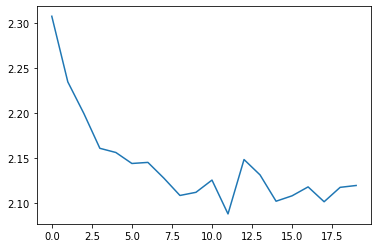

In [82]:
plt.plot(loss_epochs)

In [100]:
lstm.eval()
avg_loss=avg_eval_loss=accuracy_avg=0
with torch.no_grad():
    
    
    
    for i,data in enumerate(data_loader_test) :
    
        x_test , y_test , mask = data
        
        y_pred=lstm(x_test)
        
        
        y_pred = y_pred.view(-1, output_size)
        y_test = y_test.view(-1)
        mask = mask.view(-1)
        
#         print("Shape of y_test:", y_test.shape)
#         print("Shape of mask:", mask.shape)
#         print("Shape of non_pad_indices:", non_pad_indices.shape)


        
        non_pad_indices = mask.nonzero(as_tuple=True)[0]
        
        y_pred = y_pred[non_pad_indices]
        y_test = y_test[non_pad_indices]
            
        loss=loss_fn(y_pred,y_test)
        
        _ , y_pred=torch.max(y_pred,dim=1)
        
        accuracy=accuracy_score(y_pred,y_test)
        
        if i%1000 == 9 :
            print("Loss for batch ",i," is ",loss.item())
            print("Accuracy for batch ",i," is ",accuracy)
        
        
        avg_loss += loss.item()
        accuracy_avg += accuracy
    

Loss for batch  9  is  2.344944715499878
Accuracy for batch  9  is  0.11610486891385768


In [101]:
print("avg_loss after testing",avg_loss/(i+1))

avg_loss after testing 2.3213599197792285


In [102]:
print("accuracy_avg after testing",accuracy_avg/(i+1))

accuracy_avg after testing 0.17021258685577756
